# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

warnings.filterwarnings("ignore")

2024-07-08 16:18:17.099879: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 16:18:17.103961: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 16:18:17.117471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 16:18:17.141363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 16:18:17.141400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 16:18:17.159275: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [4]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [5]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# Load populations

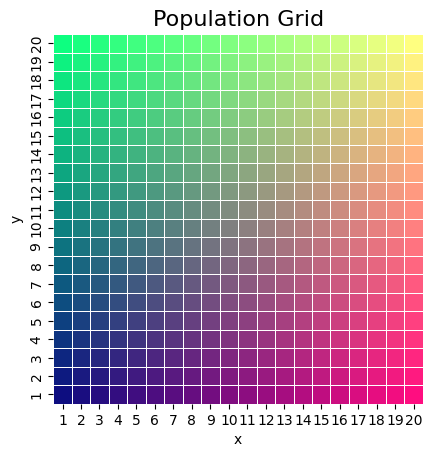

In [6]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()



# Load environmental risk

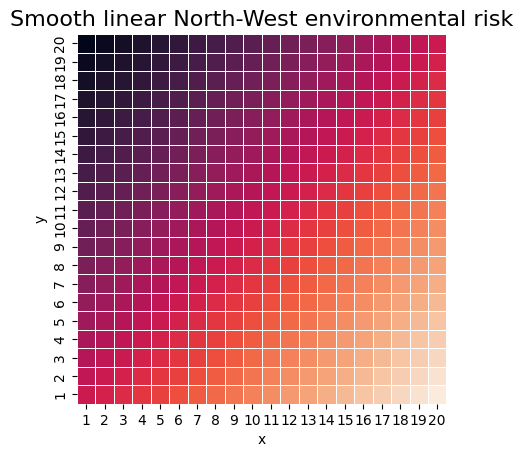

In [7]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
populations[name_risk] = risk[name_risk]
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title(f"{naming_dict[name_risk]}", fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Find true MAF per populations

In [73]:
"""
from functools import reduce
maf_dfs = []
complete['pop'] = populations['population_number']
for snp in list(complete.columns)[0:-1]:
    temp = complete[[snp,'pop']]
    indexes = []
    mafs = []
    for pop in list(populations['population_number'].unique()):
        temp2 = temp[[snp,'pop']]
        temp2 = temp2[temp2['pop']==pop]
        try:
            num_maj = temp2[[snp]].value_counts()[1]
        except Exception as e:
            num_maj = 0
        try:
            num_het = temp2[[snp]].value_counts()[0]
        except Exception as e:
            num_het = 0
        try:
            num_min = temp2[[snp]].value_counts()[-1]
        except Exception as e:
            num_min = 0
        total_humans = num_maj + num_het + num_min
        maf = (num_min*2 + num_het)/(total_humans*2)
        indexes += list(temp2.index)
        mafs += [maf]*len(temp2)
    maf_dfs.append(pd.DataFrame(data={'indexes':indexes, f"{snp}": mafs}))

# Function to merge two DataFrames on the 'indexes' column
def merge_dfs(df1, df2):
    return pd.merge(df1, df2, on='indexes')
    
# Use reduce to apply merge_dfs to all DataFrames in the list
true_population_maf_dfs = reduce(merge_dfs, maf_dfs)
true_population_maf_dfs.drop("indexes", axis=1, inplace=True)
complete.drop("pop", axis=1, inplace=True)
true_population_maf_dfs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truemafperpop.pkl")
"""

'\nfrom functools import reduce\nmaf_dfs = []\ncomplete[\'pop\'] = populations[\'population_number\']\nfor snp in list(complete.columns)[0:-1]:\n    temp = complete[[snp,\'pop\']]\n    indexes = []\n    mafs = []\n    for pop in list(populations[\'population_number\'].unique()):\n        temp2 = temp[[snp,\'pop\']]\n        temp2 = temp2[temp2[\'pop\']==pop]\n        try:\n            num_maj = temp2[[snp]].value_counts()[1]\n        except Exception as e:\n            num_maj = 0\n        try:\n            num_het = temp2[[snp]].value_counts()[0]\n        except Exception as e:\n            num_het = 0\n        try:\n            num_min = temp2[[snp]].value_counts()[-1]\n        except Exception as e:\n            num_min = 0\n        total_humans = num_maj + num_het + num_min\n        maf = (num_min*2 + num_het)/(total_humans*2)\n        indexes += list(temp2.index)\n        mafs += [maf]*len(temp2)\n    maf_dfs.append(pd.DataFrame(data={\'indexes\':indexes, f"{snp}": mafs}))\n\n# Fu

In [9]:
true_population_maf_dfs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truemafperpop.pkl")

In [76]:
true_population_maf_dfs

,CG1_AF_0.49585,CG2_AF_0.4634,CG5_AF_0.375825,CG11_AF_0.474475,CG18_AF_0.49585,CG22_AF_0.232975,CG26_AF_0.46405,CG30_AF_0.233825,CG38_AF_0.4458,CG46_AF_0.498875,...,VRG984_AF_0.001875,VRG986_AF_0.032175,VRG987_AF_0.00185,VRG988_AF_0.006625,VRG989_AF_0.045625,VRG992_AF_0.0165,VRG995_AF_0.02635,VRG996_AF_0.023175,VRG998_AF_0.00645,VRG999_AF_0.0363
0,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create environment dependend phenotype

In [77]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
precision = 0.1
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), precision))
risk['pheno'] = y
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

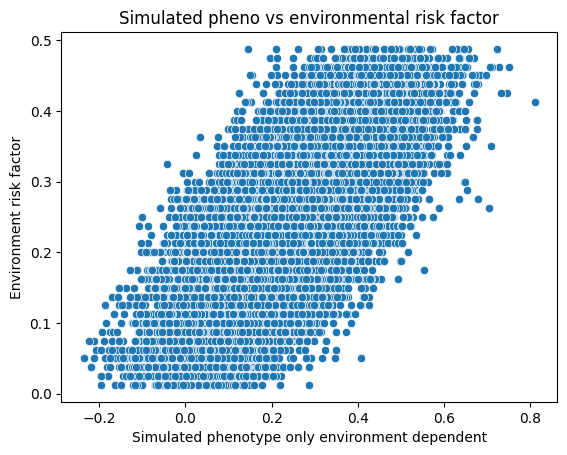

In [78]:
sns.scatterplot(x=list(y), y=list(np.array(risk[name_risk])))
plt.xlabel('Simulated phenotype only environment dependent')
plt.ylabel('Environment risk factor')
plt.title('Simulated pheno vs environmental risk factor')
plt.show()

In [79]:
df_abyss_true_maf = manhattan_linear(complete, y, true_population_maf_dfs)

Pheno is not None and not a dataframe
Abyss!


In [80]:
# risk as covariate
df_risk_as_cov = manhattan_linear(complete, y , risk[[name_risk]])

Pheno is not None and not a dataframe
Covs


In [81]:
# risk as covariate
df_pheno_as_cov = manhattan_linear(complete, y , risk[['pheno']])

Pheno is not None and not a dataframe
Covs


In [82]:
p = true_population_maf_dfs.copy()
q = 1-p

In [83]:
df_abyss_peminku = manhattan_linear(complete, y, (p-q))

Pheno is not None and not a dataframe
Abyss!


In [84]:
df_abyss_theory = manhattan_linear(complete-(p-q), y-risk[name_risk])

Pheno is not None and not a dataframe
No Covs!


In [85]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_true_maf"] = np.sort(df_abyss_true_maf['-logPs'])
df_bests["-logP_risk_as_cov"] = np.sort(df_risk_as_cov['-logPs'])
df_bests["-logP_pheno_as_cov"] = np.sort(df_pheno_as_cov['-logPs'])
df_bests["-logP_peminku"] = np.sort(df_abyss_peminku['-logPs'])
df_bests["-logP_abyss_theory"] = np.sort(df_abyss_theory['-logPs'])

In [86]:
# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

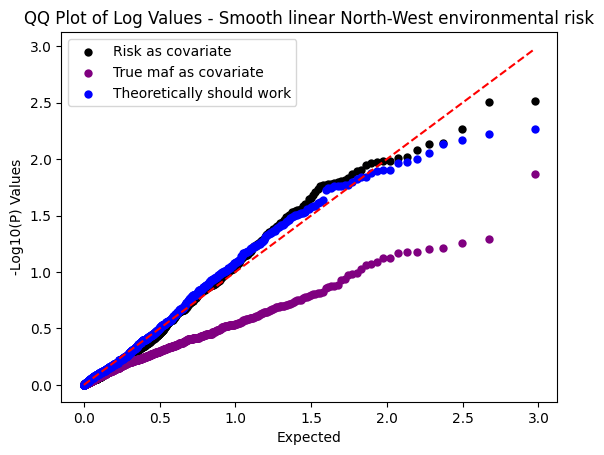

In [87]:
#sns.scatterplot(x='expected_logP', y='-logP_pheno_as_cov', data=df_bests, color='red', label='Pheno as covariate')

sns.scatterplot(x='expected_logP', y='-logP_risk_as_cov', data=df_bests, color='black', label='Risk as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_maf', data=df_bests, color='purple', label='True maf as covariate', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_true_maf', data=df_bests, color='pink', label='True peminku as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_abyss_theory', data=df_bests, color='blue', label='Theoretically should work', linewidth=0)

# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# Effect global population

mean(beta*X) = beta*(p-q)

In [93]:
complete

snps,CG1_AF_0.49585,CG2_AF_0.4634,CG5_AF_0.375825,CG11_AF_0.474475,CG18_AF_0.49585,CG22_AF_0.232975,CG26_AF_0.46405,CG30_AF_0.233825,CG38_AF_0.4458,CG46_AF_0.498875,...,VRG984_AF_0.001875,VRG986_AF_0.032175,VRG987_AF_0.00185,VRG988_AF_0.006625,VRG989_AF_0.045625,VRG992_AF_0.0165,VRG995_AF_0.02635,VRG996_AF_0.023175,VRG998_AF_0.00645,VRG999_AF_0.0363
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [94]:
type_of_mafs = []
betas = []
means = []
compared_means = []
for snp in list(complete.columns):
    type_of_maf = snp.split("_")[0].rstrip('0123456789')
    type_of_mafs.append(type_of_maf)
    maf = float(snp.split("_")[-1])
    #beta = 1/maf
    beta=0.5
    betas.append(beta)
    X = beta*complete[snp]
    mean = X.mean()
    means.append(mean)
    compared_mean = beta*((1-2*maf))
    compared_means.append(compared_mean)

In [95]:
mean_effect_df = pd.DataFrame(data={"type":type_of_mafs, "beta":betas, "mean":means, "compared_means":compared_means})

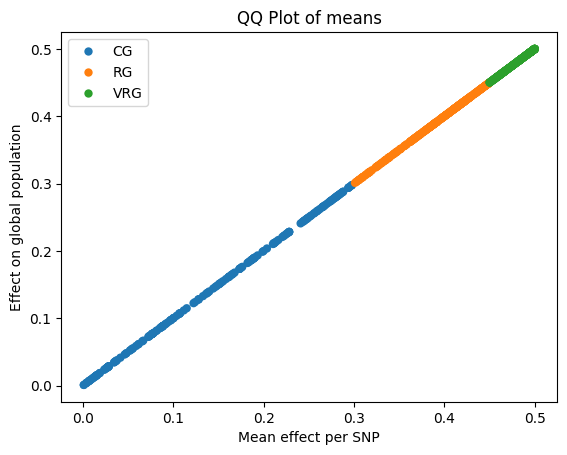

In [96]:
#sns.scatterplot(x='expected_logP', y='-logP_pheno_as_cov', data=df_bests, color='red', label='Pheno as covariate')

sns.scatterplot(x='mean', y='compared_means', data=mean_effect_df, color='blue', hue="type", linewidth=0)


# Set plot labels and title
plt.xlabel('Mean effect per SNP')
plt.ylabel("Effect on global population")
plt.title(f"QQ Plot of means")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

In [97]:
true_population_maf_dfs

,CG1_AF_0.49585,CG2_AF_0.4634,CG5_AF_0.375825,CG11_AF_0.474475,CG18_AF_0.49585,CG22_AF_0.232975,CG26_AF_0.46405,CG30_AF_0.233825,CG38_AF_0.4458,CG46_AF_0.498875,...,VRG984_AF_0.001875,VRG986_AF_0.032175,VRG987_AF_0.00185,VRG988_AF_0.006625,VRG989_AF_0.045625,VRG992_AF_0.0165,VRG995_AF_0.02635,VRG996_AF_0.023175,VRG998_AF_0.00645,VRG999_AF_0.0363
0,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.5,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.5,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Effect per sub population

In [30]:
"""
type_of_mafs = []
betas = []
means = []
compared_means = []
complete['pop'] = populations['population_number']
true_population_maf_dfs['pop'] = populations['population_number']
for snp in list(complete.columns)[0:-1]:
    temp_snps = complete[[snp,'pop']]
    true_population_maf_dfs_temp = true_population_maf_dfs[[snp,'pop']]
    for pop in list(populations['population_number'].unique()):
        temp_snps_2 = temp_snps[temp_snps['pop']==pop]
        true_population_maf_dfs_temp_2 = true_population_maf_dfs_temp[true_population_maf_dfs_temp['pop']==pop]
        maf =  true_population_maf_dfs_temp_2[snp].iloc[0]
        beta = 1/maf
        beta = 0.2
        betas.append(beta)
        X = beta*temp_snps_2[snp]
        mean = X.mean()
        means.append(mean)
        compared_mean = beta*((1-2*maf))
        compared_means.append(compared_mean)
        type_of_mafs.append(snp.split("_")[0].rstrip('0123456789'))
complete.drop("pop", axis=1, inplace=True)
true_population_maf_dfs.drop("pop", axis=1, inplace=True)
mean_effect_df = pd.DataFrame(data={"type":type_of_mafs, "beta":betas, "mean":means, "compared_means":compared_means})

#sns.scatterplot(x='expected_logP', y='-logP_pheno_as_cov', data=df_bests, color='red', label='Pheno as covariate')

sns.scatterplot(x='mean', y='compared_means', data=mean_effect_df, color='blue', hue="type", linewidth=0)


# Set plot labels and title
plt.xlabel('Mean effect per SNP')
plt.ylabel("Effect on global population")
plt.title(f"QQ Plot of means")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()
"""

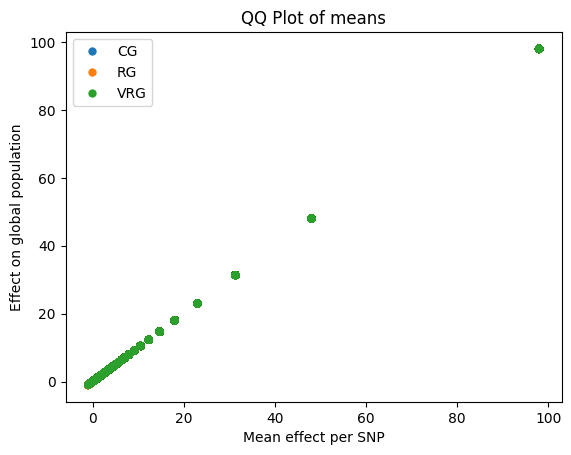